In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.io
from scipy.interpolate import Rbf


**Goal**

The goal of this assignment is to locate the source of polution using real data obtained from USGS.

You are given flow data (in cm/day) and the loacations where the concetration of lead in the water was bigger than 15 ppb at a few stations.

In these cases engineers are asked to find the source of polution (where) and the time/time span the polution took place.

You will need to use what you learned in this course to achieve this task.




In [ ]:
# load the data from your computer
from google.colab import files
uploaded = files.upload()

In [ ]:
!ls

In [ ]:
# read the data
data = scipy.io.loadmat('flow.mat')
X = data['x']
Y = data['y']
U = data['u']
V = data['v']

X = X[:,:,0]
Y = Y[:,:,0]
U = U[:,:,10]
V = V[:,:,10]

In [ ]:
# plot the flow field and its magnitude
fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)

In [ ]:
# plot the flow magnitude
a = np.sqrt(U**2 + V**2)
plt.contourf(X.reshape(35,41),Y.reshape(35,41),a)
plt.colorbar()


**The polution file**

Next we load the location of lead polution as observed in 20 stations in different locations.

We plot the locations of the lead polution as observed on the same day together with the flow.


In [ ]:
# Get the polution data
from google.colab import files
p = files.upload()

In [ ]:
data = scipy.io.loadmat('dataXY.mat')
XY = data['XY']
Xfinal = XY[:,0]
Yfinal = XY[:,1]


In [ ]:
# plot it on the same field as the flow
fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)
ax.plot(Xfinal,Yfinal,'*')

Assignment

1. Write a code that traces particles in the given velocity field. Note that you will need to interpolate the flow filed for that.

2. Given the locations of the particles (the measurement stations), trace them backward to find the path of the particles.

3. Plot the path of the particles and estimate the location the polution started from

4. Evaluate the propagation of the polution in the next few days.

In [ ]:
def RBFfun(x,y,xI,yI,sigma):
    phi = torch.exp(-((x-xI)**2 + (y-yI)**2)/sigma**2)
    return phi

In [ ]:
def RBFmatrix(x,y,sigma):

    n = x.shape[0]
    A = torch.zeros(n,n)
    xI = x.reshape(x.shape[0], 1)
    yI = y.reshape(y.shape[0], 1)
    A = torch.exp(-((x-xI)**2 + (y-yI)**2)/sigma**2)

    return A

In [ ]:
def RBFinterp(x,y,f,xI,yI,sigma):

    # Compute the RBF matrix
    A = RBFmatrix(x,y,sigma);

    # Compute the coefficients
    c, LU = torch.solve(f.unsqueeze(1),A)

    # Compute the data on the new points
    nI = xI.shape[0]
    n  = x.shape[0]
    vI = torch.zeros(nI)
    for i in range(nI):
        for j in range(n):
            vi = c[j]*RBFfun(x[j],y[j],xI[i],yI[i],sigma)
            vI[i] += vi[0];

    return vI

In [ ]:
#Question 1
X = torch.Tensor(X.reshape(1435))
Y = torch.Tensor(Y.reshape(1435))
U = torch.Tensor(U.reshape(1435))
V = torch.Tensor(V.reshape(1435))
Xfinal = torch.Tensor(Xfinal)
Yfinal = torch.Tensor(Yfinal)

Uvec = RBFinterp(X,Y,U,Xfinal,Yfinal,sigma)
Vvec = RBFinterp(X,Y,V,Xfinal,Yfinal,sigma)

print('The flow vector in x direction of current particles: ')
print(Uvec)

print('The flow vector in y direction of current particles: ')
print(Vvec)

In [ ]:
def prop_past(x0, y0,Uvec,Vvec,dt, N):

    x = torch.zeros(N)
    y = torch.zeros(N)

    for i in range(N):
     x[i] = x0[i] - dt*Uvec[i]
     y[i] = y0[i] - dt*Vvec[i]

    return x,y

In [ ]:
def prop_future(x0, y0,Uvec,Vvec,dt, N):

    x = torch.zeros(N)
    y = torch.zeros(N)

    for i in range(N):
     x[i] = x0[i] + dt*Uvec[i]
     y[i] = y0[i] + dt*Vvec[i]

    return x,y

In [ ]:
def propN(x0,y0,Uvec,Vvec,dt,n,X,Y,U,V,Condition):
 N= x0.numel() #number of particles
 Xs = torch.zeros(n,N)
 Ys = torch.zeros(n,N)

 for j in range(n):
   if Condition == 0:
    x,y = prop_past(x0,y0,Uvec,Vvec,dt,N)
   else:
    x,y = prop_future(x0,y0,Uvec,Vvec,dt,N)

   Xs[j,:] = x
   Ys[j,:] = y
   Uvec = RBFinterp(X,Y,U,x,y,sigma)
   Vvec = RBFinterp(X,Y,V,x,y,sigma)
   x0 = x
   y0 = y

 return Xs, Ys

In [ ]:
#number 2

n = 11
Xp,Yp = propN(Xfinal,Yfinal,Uvec,Vvec,0.1,n, X, Y, U,V,0)

print("the past particle cordinates are: ")

print("The X cordinates: ")
print(Xp)

print("The Y cordinates: ")
print(Yp)

#number 3
fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)
ax.plot(Xfinal, Yfinal,'*')

for i in range(11):
 ax.plot(Xp[i],Yp[i],'*')
#the particle population flows from the left to the right it most likely comes from somewhere in the upper/middle left of graph as
#the vectors with greatest magnitude are coming from that direction making them most likely to carry the particles.

the future particle cordinates are: 
The X cordinates: 
tensor([[117.6068, 117.5957, 117.2647, 116.4435, 115.3421, 113.5753, 112.0993,
         110.7822, 110.1562, 109.4292, 109.0383, 108.8531, 108.7629, 108.7550,
         108.8038, 108.8885, 109.0456, 109.3167, 109.6006, 110.0129],
        [121.1598, 121.1612, 120.7202, 120.0588, 119.2513, 117.4781, 115.5738,
         113.7097, 112.9662, 111.9379, 111.5286, 111.2971, 111.1435, 111.0582,
         111.0295, 111.0324, 111.0901, 111.2428, 111.4957, 111.9934],
        [125.2431, 125.1849, 124.3886, 123.6808, 122.3963, 120.8944, 119.0349,
         116.8367, 115.6090, 114.4295, 113.7910, 113.3964, 113.1599, 113.0169,
         112.9376, 112.8914, 112.9052, 113.0352, 113.3260, 113.8677],
        [128.7583, 129.0757, 128.7231, 127.3978, 125.7169, 123.9517, 122.0923,
         120.1480, 118.3446, 116.8752, 116.1555, 115.6326, 115.2151, 114.9422,
         114.7816, 114.6727, 114.6427, 114.7636, 115.1060, 115.6330],
        [132.5265, 133.2472, 132

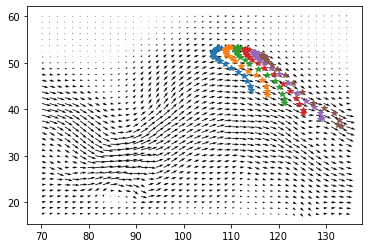

In [ ]:
#number 4
n = 5
Xf,Yf = propN(Xfinal,Yfinal,Uvec, Vvec,0.1,n, X, Y, U,V,1)

print("the future particle cordinates are: ")

print("The X cordinates: ")
print(Xf)

print("The Y cordinates: ")
print(Yf)

fig, ax = plt.subplots()
ax.quiver(X,Y,U,V)
ax.plot(Xfinal, Yfinal,'*')

for i in range(5):
 ax.plot(Xf[i],Yf[i],'*')

 #the population moves to the right over the few days following the vectors with greatest magnitude toward the middle right side of graph

0
0.002
1
0.004
2
0.008
3
0.016
4
0.032
5
0.064
6
0.128
7
0.256
8
0.512
9
1.024
10
2.048
11
4.096
12
8.192
13
16.384
14
32.768
15
65.536
the lowest error tensor(3.4990)
the optimal sigma with lowest error tensor(1.0240)


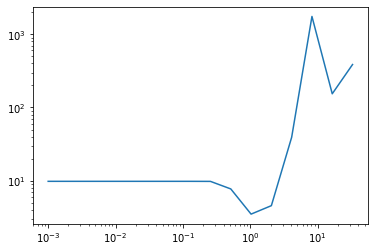

In [ ]:
k = 16

xT = Xfinal[:k]; yT = Yfinal[:k]  # training
xV = Xfinal[k:]; yV = Yfinal[k:]  # validating

Avec = torch.sqrt(Uvec**2 + Vvec**2)
fT = Avec[:k]
fV = Avec[k:]

sigma = 1e-3
sig = torch.zeros(16)
r = torch.zeros(16)
for i in range(16):
    fV_est = RBFinterp(xT,yT,fT,xV,yV,sigma);
    err = torch.abs(fV - fV_est).max()

    #compute interpolation and error and record sigma and the error
    sig[i] = sigma
    r[i]   = err
    sigma *= 2
    print(i)
    print(sigma)
 # Print the optimal value of sigma

plt.loglog(sig,r)
minVal = min(r)
print("the lowest error", minVal)
minloc = int((r==minVal).nonzero(as_tuple=True)[0]) # find index
print("the optimal sigma with lowest error", sig[minloc])
sigma = sig[minloc]